### Objective : "To analyze customer reviews of Indian domestic airlines using text analytics techniques, including sentiment analysis, topic modeling, and classification modeling, to uncover key customer sentiment drivers, recurring themes, and actionable insights for enhancing customer satisfaction and operational efficiency."


# Section 1: Import Libraries


In [259]:

import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
from sklearn.feature_extraction.text import TfidfVectorizer  # For text vectorization
from sklearn.model_selection import train_test_split  # For splitting dataset into training and testing sets
from sklearn.linear_model import LogisticRegression  # For building a logistic regression model
from sklearn.metrics import (
    accuracy_score,  # To measure model accuracy
    precision_score,  # To measure precision
    recall_score,  # To measure recall
    f1_score,  # To measure F1 score
    classification_report,  # To generate a detailed classification report
    confusion_matrix  # To visualize the confusion matrix
)
from sklearn.decomposition import LatentDirichletAllocation  # For topic modeling
from wordcloud import WordCloud  # For visualizing word clouds
import seaborn as sns  # For advanced visualizations
import re  # For regular expression-based text preprocessing
import nltk  # For text preprocessing
from nltk.corpus import stopwords  # For removing common stopwords
from nltk.stem import WordNetLemmatizer  # For lemmatizing words (reducing words to their root form)
import textblob as tb  # For sentiment analysis
from textblob import TextBlob  # For sentiment analysis


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



# Section 2: Load and Clean dataset


In [260]:

# Load dataset
df = pd.read_csv('Indian_Domestic_Airline.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [261]:
# Display column names and sample data
print(df.columns)

Index(['AirLine_Name', 'Rating - 10', 'Title', 'Name', 'Date', 'Review',
       'Recommend'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Metadata**

Dataset Name: Indian Domestic Airline Reviews

Source: Skytrax Reviews

AirLine_Name: It has seven different airline companies name are mentioned

Rating:  This is the rating for the service (1 to 10)

Title: In short title of the review

Name: Name of the passenger

Date: Date from 2016 to 2023

Review: These the subjective text comments/reviews/suggestions given by the customer/passenger

Recommend: Does the passenger recommends the service to others


In [262]:
print(df.head())
print(df.info())

    AirLine_Name  Rating - 10                          Title  \
0  AirAsia India          6.0          "crew were welcoming"   
1  AirAsia India          1.0     "furious and disappointed"   
2  AirAsia India         10.0  "amazing service and support"   
3  AirAsia India          1.0      "Waste of time and money"   
4  AirAsia India          8.0   "thumbs up to boarding crew"   

                     Name               Date  \
0                V Bakshi  14th October 2023   
1                 G Oscar  14th October 2023   
2             Rahul Verma  14th October 2023   
3                 G Akron  14th October 2023   
4  Sirajudeen Jawahar ali  14th October 2023   

                                              Review Recommend  
0  ✅ Trip Verified | I had booked this fare at a ...       yes  
1  ✅ Trip Verified | I travel at least four times...        no  
2  ✅ Trip Verified | Taking this opportunity to a...       yes  
3  ✅ Trip Verified | The worst airlines in the hi...        no  
4

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [263]:
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 AirLine_Name    0
Rating - 10     4
Title           0
Name            0
Date            0
Review          0
Recommend       0
dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [264]:

# Handle missing values
df['Rating - 10'].fillna(df['Rating - 10'].median(), inplace=True) # Fill missing numerical values with the median
# Check for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 AirLine_Name    0
Rating - 10     0
Title           0
Name            0
Date            0
Review          0
Recommend       0
dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-264-e80cdaf5ed0e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Rating - 10'].fillna(df['Rating - 10'].median(), inplace=True) # Fill missing numerical val

# Section 3: Text Preprocessing

In [265]:
# Clean the 'review' column
# Preprocessing with Lemmatization, Stopword Removal, and Regex Cleaning

# Download stopwords and lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Apply preprocessing to the 'review' column
def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
        text = text.lower()  # Lowercase conversion
        text = text.split()  # Tokenization
        text = [word for word in text if word not in stop_words]  # Remove stopwords
        text = [lemmatizer.lemmatize(word) for word in text]  # Lemmatization
        return ' '.join(text)  # Rejoin into a single string
    return ""

# Apply preprocessing to the review column
df['Review'] = df['Review'].apply(preprocess_text)

# Check the cleaned data
print(df['Review'].head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    trip verified booked fare discounted rate need...
1    trip verified travel least four time month air...
2    trip verified taking opportunity appreciate th...
3    trip verified worst airline history mankind ab...
4    trip verified would like give big thumb boardi...
Name: Review, dtype: object


**OBSERVATION**

**Text Preprocessing**: Reviews were cleaned by:
Removing non-alphabetical characters.
Lowercasing text.
Removing stopwords.
Lemmatizing words for root forms.

**Outcome:** The Review column is now cleaner, standardized, and ready for , Sentiment Analysis, Topic Modeling and Classification model building.


# Section 4: Exploratory Data Analysis (EDA)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


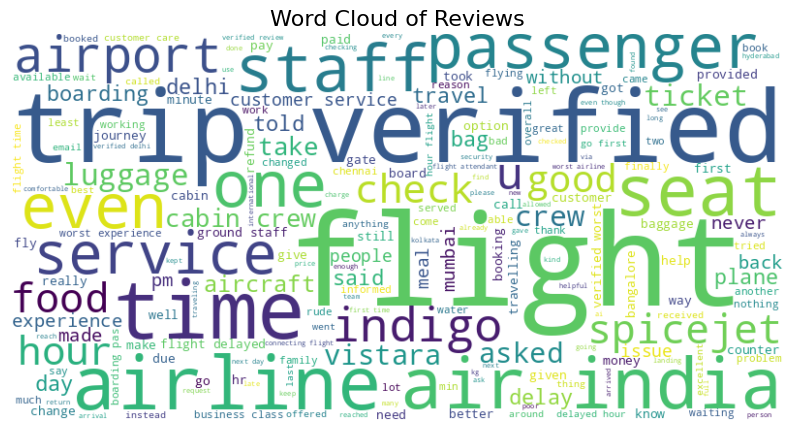

In [266]:
# Word Cloud of Reviews

# Combine all reviews into a single string for the Word Cloud
all_reviews = ' '.join(df['Review'])

# Generate the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(all_reviews)

# Plot the Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews', fontsize=16)
plt.show()

This Word Cloud visualizes the most frequent terms from the airline reviews. Key observations include:

**Dominant Words:**

Terms like "flight", "time", "staff", "seat", "verified", "trip", and "passenger" and "service" appear prominently.


**Airline Mentions:**

Specific airlines such as "Air India", "IndiGo", and "SpiceJet" feature prominently, suggesting they are frequently reviewed.


**Pain Points:**

Words like "delay", "luggage", "refund", and "issue" highlight recurring concerns, particularly related to flight delays and baggage handling.
Positive

**Feedback:**

Terms such as "good", "experience", and "crew" reflect positive sentiments about customer service and inflight experiences.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


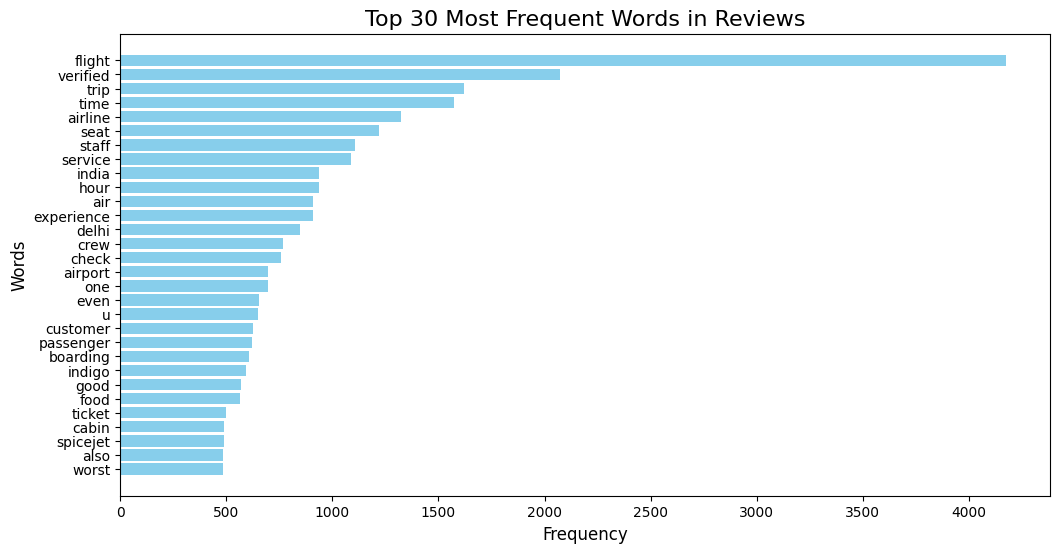

          Word  Frequency
0       flight       4174
1     verified       2073
2         trip       1620
3         time       1572
4      airline       1323
5         seat       1220
6        staff       1105
7      service       1088
8        india        937
9         hour        935
10         air        908
11  experience        907
12       delhi        848
13        crew        768
14       check        757
15     airport        698
16         one        696
17        even        655
18           u        651
19    customer        625
20   passenger        622
21    boarding        605
22      indigo        593
23        good        570
24        food        566
25      ticket        497
26       cabin        491
27    spicejet        488
28        also        486
29       worst        485


In [267]:
##Frequency of Top 30 Words
from collections import Counter
words = all_reviews.split()
word_counts = Counter(words)
top_words = word_counts.most_common(30)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Plot the Top 30 Words
plt.figure(figsize=(12, 6))
plt.barh(top_words_df['Word'], top_words_df['Frequency'], color='skyblue')
plt.title('Top 30 Most Frequent Words in Reviews', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.gca().invert_yaxis()
plt.show()

print(top_words_df)

Removing Domain specific words which are obvious to occur and don't carry insights

In [268]:
# Define domain-specific words
domain_specific_words = {'flight', 'airline', 'seat', 'trip', 'luggage', 'passenger',
                         'crew', 'service', 'boarding', 'cabin', 'airport', 'verified',
                         'india', 'time', 'one', 'also', 'even', 'hour', 'u'}

# Function to remove domain-specific words
def remove_domain_specific_words(text):
    if isinstance(text, str):
        text = text.split()  # Tokenization
        text = [word for word in text if word not in domain_specific_words]  # Remove domain-specific words
        return ' '.join(text)  # Rejoin words into a single string
    return ""

# Apply function to the 'Review' column
df['Review_Cleaned'] = df['Review'].apply(remove_domain_specific_words)

# Check the cleaned reviews
print(df[['Review', 'Review_Cleaned']].head())

                                              Review  \
0  trip verified booked fare discounted rate need...   
1  trip verified travel least four time month air...   
2  trip verified taking opportunity appreciate th...   
3  trip verified worst airline history mankind ab...   
4  trip verified would like give big thumb boardi...   

                                      Review_Cleaned  
0  booked fare discounted rate needed travel back...  
1  travel least four month air asia truly ruin un...  
2  taking opportunity appreciate thank entire tea...  
3  worst history mankind absolutely hate recommen...  
4  would like give big thumb m noor tiruchirappal...  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Original Reviews:**

The original reviews contain many domain-specific words like **"trip," "verified**," **"flight," and "passenger,**  which do not provide significant insights for deeper text analysis or sentiment understanding.

**Cleaned Reviews:**

After preprocessing:

Domain-specific words have been successfully removed.
The cleaned reviews focus on more meaningful and actionable terms such as **"discounted rate," "taking opportunity," and "big thumb."**

**Preservation of Context:**

While removing redundant words, the cleaned reviews still retain sufficient context to analyze customer sentiment and key themes **(e.g., appreciation, complaints, or suggestions).**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


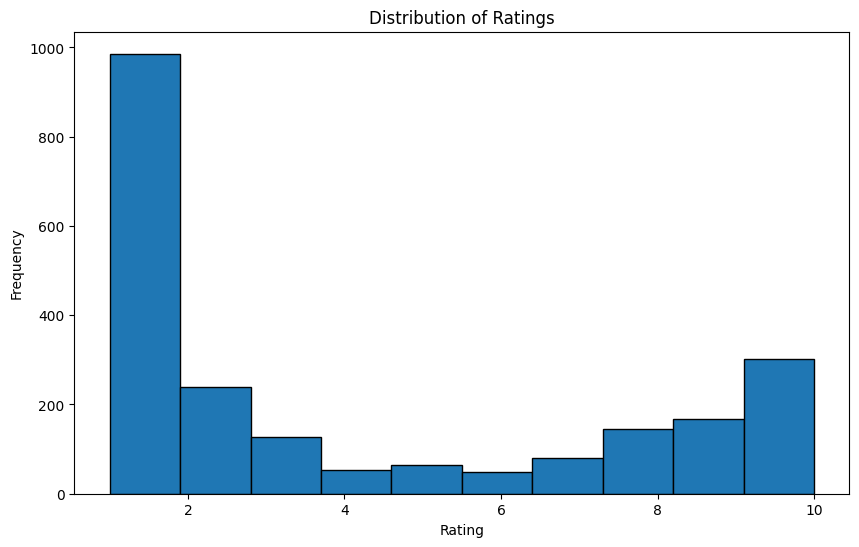

In [269]:

# Plot distribution of ratings
plt.figure(figsize=(10, 6))
df['Rating - 10'].plot(kind='hist', bins=10, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


**OBSERVATION**

Observation:

The majority of ratings are concentrated at **1 and 2**, indicating a large proportion of highly dissatisfied customers.

There is a visible rise in ratings at **8 and 10**, showing a subset of highly satisfied customers.

Ratings in the middle range **(4–6)** are less frequent, suggesting polarized customer experiences..

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


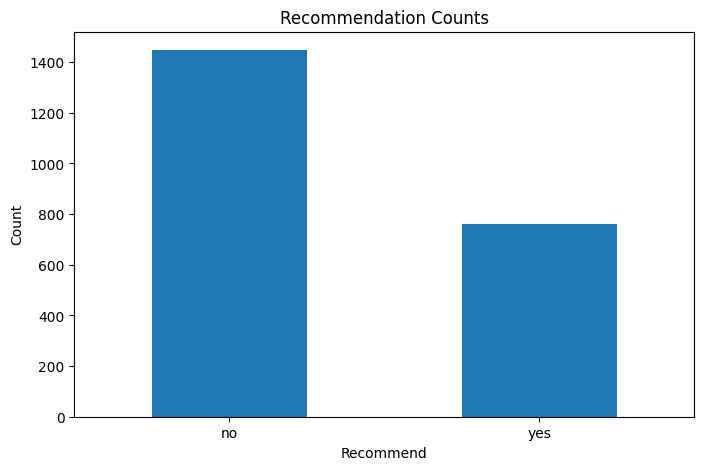

In [270]:
# Plot recommendation counts
recommendation_counts = df['Recommend'].value_counts()
plt.figure(figsize=(8, 5))
recommendation_counts.plot(kind='bar')
plt.title('Recommendation Counts')
plt.xlabel('Recommend')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


**OBSERVATION**
1. Imbalance in Sentiment Analysis
A higher proportion of "No" recommendations aligns with negative sentiments, potentially skewing the sentiment analysis.
The negative bias may overemphasize recurring issues like delays, poor service, or grievances.

2. Impact on Classification Models
The imbalance in the target variable (recommendation) could lead to a biased classification model, where the model predicts "No" more often than "Yes."

**Action**: If we don't get expected results in the models, we will apply techniques like oversampling/undersampling or using class weights to balance the dataset for better classification performance in further analysis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


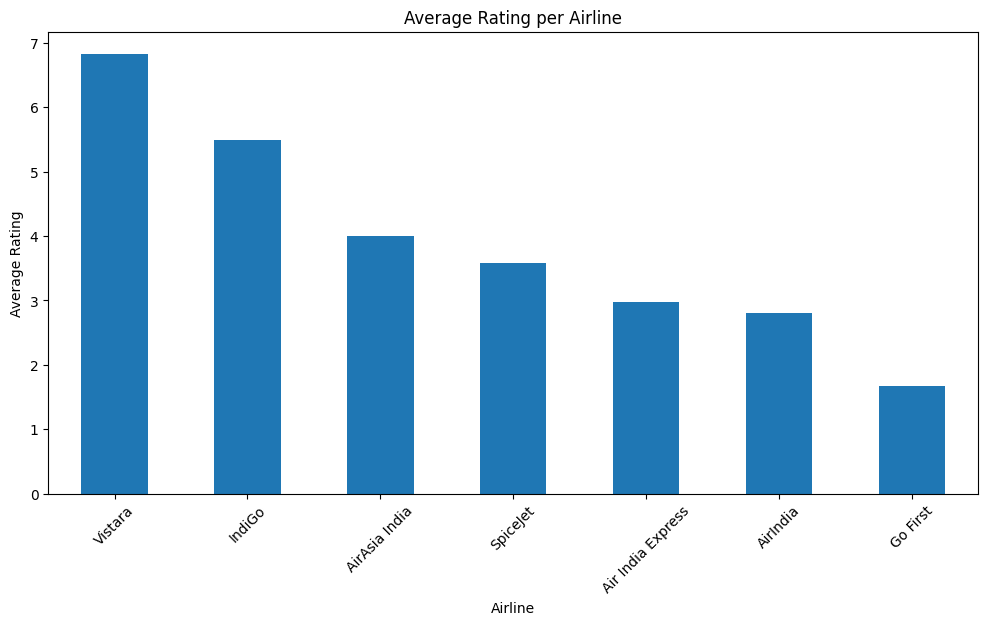

In [271]:
# Average rating per airline
avg_rating_per_airline = df.groupby('AirLine_Name')['Rating - 10'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
avg_rating_per_airline.plot(kind='bar')
plt.title('Average Rating per Airline')
plt.xlabel('Airline')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()


**OBSERVATION**

**Average Rating Per Airline:**

Airlines like Vistara and IndiGo consistently score higher in average ratings.

Airlines like Air India and SpiceJet show lower average ratings.

**Outcome:** Clear differences in airline performance suggest that some airlines excel in customer satisfaction, while others need targeted improvements.




# Section 5: Sentiment Analysis


In [272]:

def get_sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity if text else 0.0

df['sentiment_polarity'] = df['Review'].apply(get_sentiment_polarity)

def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_polarity'].apply(classify_sentiment)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


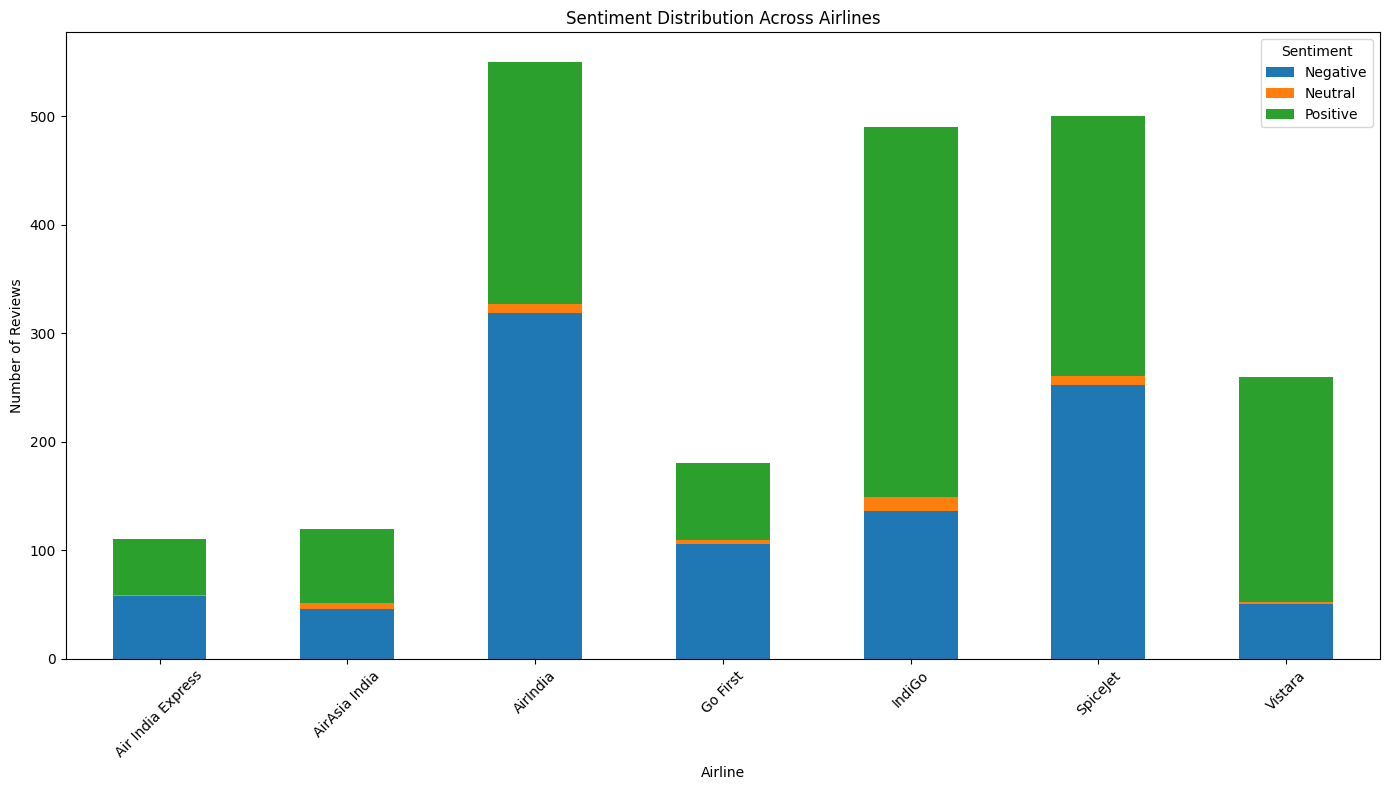

In [273]:
# Sentiment Analysis per Airline (Single Plot)
sentiment_summary = df.groupby(['AirLine_Name', 'sentiment']).size().unstack(fill_value=0)
ax = sentiment_summary.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Sentiment Distribution Across Airlines')
plt.xlabel('Airline')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

**OBSERVATION**

**Sentiment Distribution Across Airlines:**

IndiGo and Vistara: Higher proportion of positive sentiments.

Air India and SpiceJet: Higher proportion of negative sentiments.

**Outcome:** Airlines with higher negative sentiments must prioritize operational efficiency and customer grievance redressal.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1400x800 with 0 Axes>

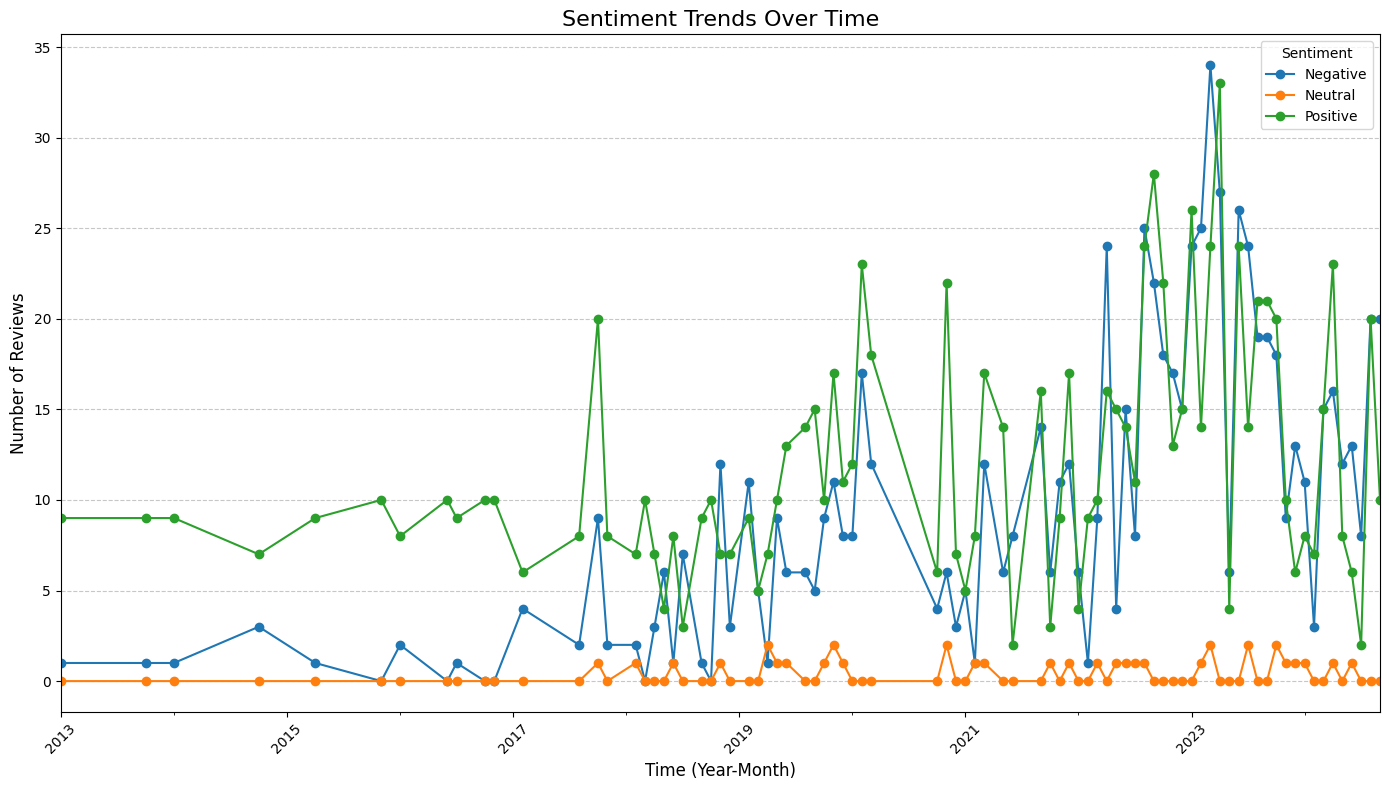

In [274]:
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract year and month from the date for grouping
df['YearMonth'] = df['Date'].dt.to_period('M')

# Group sentiments by time periods
sentiment_trends = df.groupby(['YearMonth', 'sentiment']).size().unstack(fill_value=0)

# Plot sentiment trends over time
plt.figure(figsize=(14, 8))
sentiment_trends.plot(kind='line', marker='o', figsize=(14, 8))
plt.title('Sentiment Trends Over Time', fontsize=16)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Inference for Sentiment Trends Over Time**

**Positive Sentiment Dominance:** The green line representing positive sentiment consistently stays higher compared to negative and neutral sentiments. This indicates that, over time, customers generally had more positive experiences.


**Fluctuations in Sentiment:**There are noticeable spikes and dips in positive sentiment, particularly around 2019 and 2023, which could correlate with specific events or improvements in services offered by airlines.

**Negative sentiment (blue line**) also shows periodic increases, possibly linked to operational challenges, delays, or service failures during certain months.

**Neutral Sentiment Stability:** Neutral sentiments (orange line) remain consistently low throughout the timeline, suggesting that most reviews lean toward definitive opinions (positive or negative).


**Trends Around 2020–2021**:There is a dip in all sentiment types during this period, which could be attributed to the global reduction in air travel during the COVID-19 pandemic.


**Increase in Engagement Post-2021:**A significant rise in both positive and negative sentiments after 2021 indicates a resurgence in air travel and increased customer feedback. Airlines may have introduced new services or faced challenges scaling operations during the recovery period.

**Sentiments Trend over time Airline wise**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 500x300 with 0 Axes>

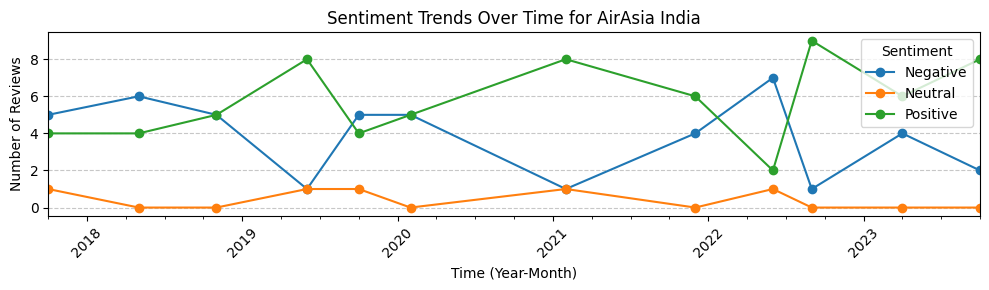

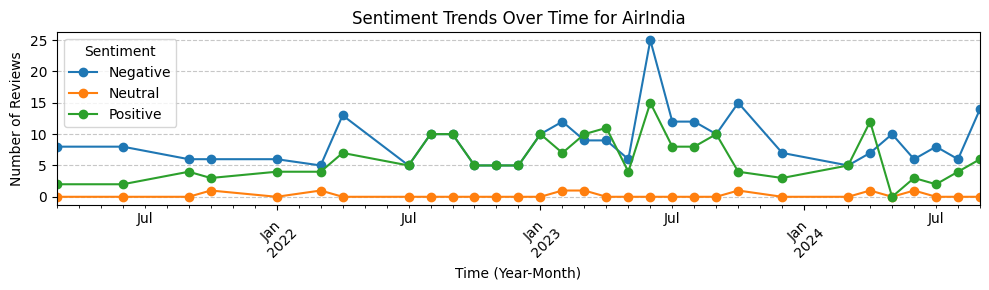

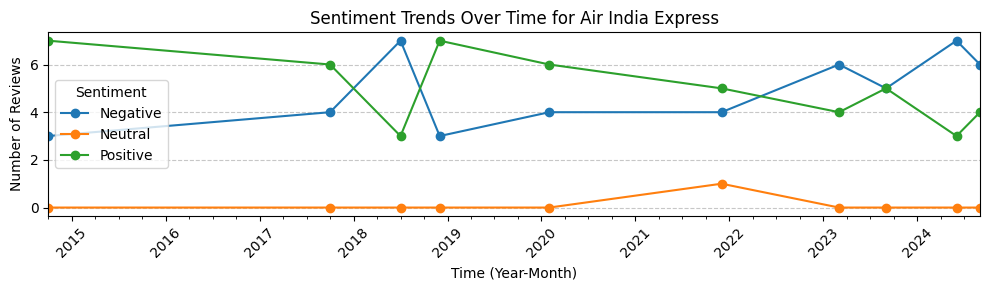

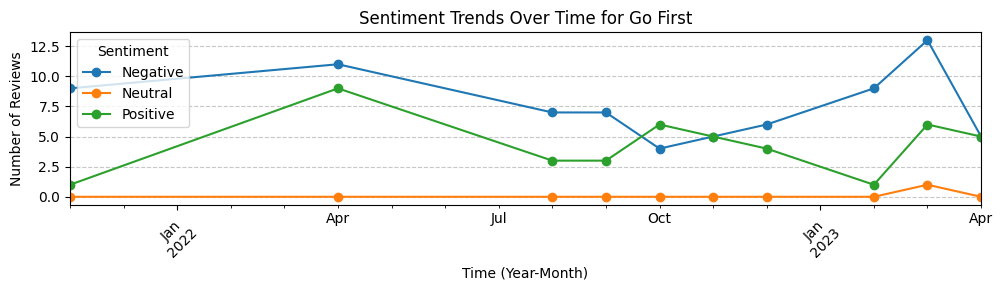

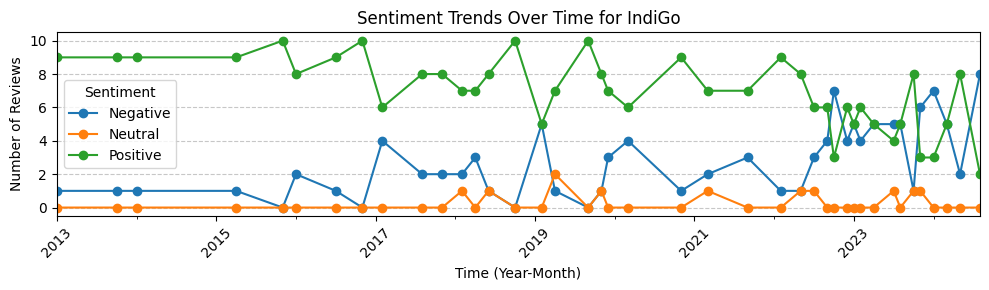

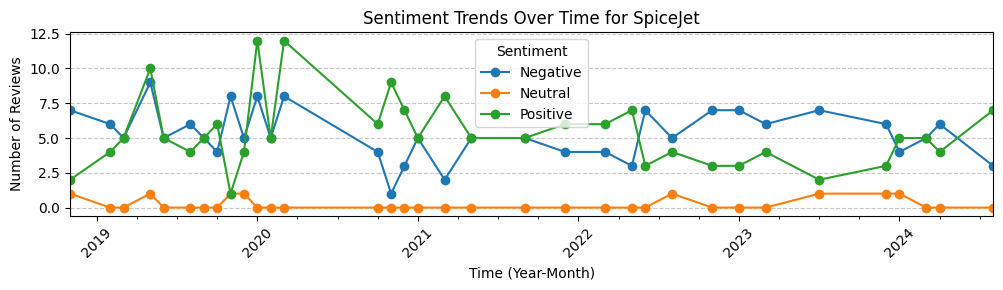

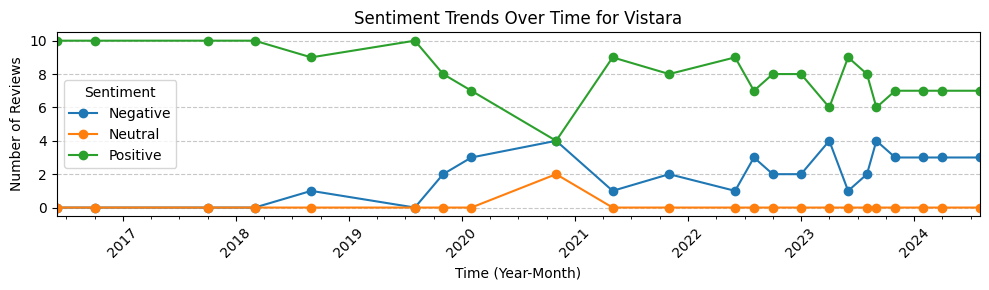

In [275]:
# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract year and month from the date for grouping
df['YearMonth'] = df['Date'].dt.to_period('M')

# Group data by airline, sentiment, and time period
airline_sentiment_trends = df.groupby(['AirLine_Name', 'YearMonth', 'sentiment']).size().unstack(fill_value=0)

# Plot sentiment trends for each airline
airlines = df['AirLine_Name'].unique()

plt.figure(figsize=(5, 3))

for airline in airlines:
    # Filter data for each airline
    airline_data = airline_sentiment_trends.loc[airline]

    # Plot each airline's sentiment trends
    airline_data.plot(kind='line', marker='o', figsize=(10, 3), title=f"Sentiment Trends Over Time for {airline}")
    plt.xlabel('Time (Year-Month)')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=45)
    plt.legend(title='Sentiment')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



**General Insights:**

**Positive Sentiments**: Airlines like IndiGo and Vistara show the highest consistency in positive trends, indicating strong customer satisfaction.

**Negative Sentiments:** AirIndia and SpiceJet exhibit significant spikes, reflecting potential operational or service-related challenges during specific periods.

**Neutral Sentiments:** Across all airlines, neutral sentiments are consistently low, showing that most customers tend to share decisive opinions.


# Section 6: Topic Modelling

Which topics names are most discussed?


In [276]:
# Identify key themes in customer reviews using LDA
vectorizer = TfidfVectorizer(max_df=0.85, min_df=5, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['Review_Cleaned'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_components=5, random_state=42)

In [277]:
# Using TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.85, min_df=5, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['Review_Cleaned'])

# Fit LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display topics
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        topics[f"Topic {topic_idx + 1}"] = [feature_names[i] for i in topic.argsort()[-no_top_words:]]
    return topics

topics = display_topics(lda, vectorizer.get_feature_names_out(), 10)

# Print topics
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1: entertainment, extra, worst, baggage, experience, bag, staff, working, air, kg
Topic 2: wifi, extremely, dxb, lcc, ranchi, tab, realise, inedible, poor, student
Topic 3: air, mumbai, vistara, check, delhi, food, indigo, experience, staff, good
Topic 4: book, booked, delayed, spicejet, ticket, cancelled, refund, worst, day, customer
Topic 5: measure, visakhapatnam, provides, wheel, senior, chair, citizen, hindi, daughter, compare


**Observation**

Topics extracted here focus on individual keywords, often missing contextual relationships between terms. For instance, "air," "staff," and "bag" in Topic 1 appear disjointed without providing a clear narrative. We will incorporate "bigrams" and "trigrams" to get clear context and narratives

**Incorporating bigrams and trigrams to get clear context and narratives**

In [278]:
# Update vectorizer to include bigrams and trigrams
vectorizer = TfidfVectorizer(max_df=0.85, min_df=5, stop_words='english', ngram_range=(1, 3))
tfidf_matrix = vectorizer.fit_transform(df['Review_Cleaned'])

# Fit LDA on the new matrix
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display topics with n-grams
topics = display_topics(lda, vectorizer.get_feature_names_out(), 10)
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1: patna, laptop bag, arrival, good experience, clean fresh, extra charge, departure arrival, staff polite, laptop, kg
Topic 2: indigo, staff, excellent, comfortable, vistara, meal, aircraft, experience, food, good
Topic 3: day, ticket, experience, delhi, spicejet, air, delayed, worst, customer, staff
Topic 4: cancelled reason, pathetic customer, waiting refund, kudos, day journey, knowledge, cancelled ticket, abu, dhabi, abu dhabi
Topic 5: doctor, transport, power, chennai worst, manually, button, good ground, got canceled, unprofessional rude, extremely rude


**Observation**
Multi-word topics enable better mapping to sentiments, helping link specific complaints or praises to actionable points for businesses. For instance, "clean fresh" reflects positive feedback, whereas "got canceled" aligns with negative sentiments.

Incorporating bigrams and trigrams provides richer context, as seen in the refined topics:

Topic 1: "staff polite," "departure arrival," and "clean fresh" convey specific service-related aspects.

Topic 3: "worst delayed," "air spicejet," and "experience ticket" highlight complaints tied to delays and ticketing.

Topic 5: "extremely rude," "unprofessional rude," and "got canceled" clearly express dissatisfaction


**Airline-Specific Topic Modeling**


In [279]:
# Airline-Specific Topic Modeling with bi-gram and tr
for airline in df['AirLine_Name'].unique():
    subset = df[df['AirLine_Name'] == airline]
    if subset['Review_Cleaned'].dropna().shape[0] > 5:
        # Update vectorizer with refined parameters
        vectorizer = TfidfVectorizer(
            max_df=0.85,
            min_df=5,  # Increase min_df to filter out uncommon terms
            stop_words='english',
            ngram_range=(2, 3),  # Focus on bigrams and trigrams only
            max_features=1000
        )
        tfidf_matrix_airline = vectorizer.fit_transform(subset['Review_Cleaned'])

        # Fit LDA with adjusted topic number
        lda_airline = LatentDirichletAllocation(n_components=3, random_state=42)  # Fewer topics for clarity
        lda_airline.fit(tfidf_matrix_airline)

        # Display topics
        topics_airline = display_topics(lda_airline, vectorizer.get_feature_names_out(), 10)
        print(f"\n **Topics for {airline}:**")
        for topic, words in topics_airline.items():
            print(f"- {topic}: {', '.join(words)}")





 **Topics for AirAsia India:**
- Topic 1: bad experience, check baggage, booked ticket, worst experience, low cost, air asia, new delhi, flying airasia, web check, ground staff
- Topic 2: flying airasia, worst experience, low cost, ground staff, new delhi, air asia, web check, check baggage, booked ticket, bad experience
- Topic 3: bad experience, web check, booked ticket, flying airasia, ground staff, new delhi, low cost, check baggage, worst experience, air asia


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



 **Topics for AirIndia:**
- Topic 1: tray table, booked ticket, delayed hr, value money, early morning, tv working, got delayed, bad experience, customer care, ground staff
- Topic 2: took minute, inflight entertainment, check counter, food served, entertainment screen, screen work, food good, entertainment work, air staff, air hostess
- Topic 3: staff rude, entertainment working, technical issue, new delhi, flying air, food quality, screen working, fly air, worst experience, business class

 **Topics for Air India Express:**
- Topic 1: customer care, worst experience, fly air express, fly air, new delhi, ground staff, air express, leg space
- Topic 2: leg space, customer care, worst experience, fly air express, fly air, new delhi, ground staff, air express
- Topic 3: leg space, air express, new delhi, fly air express, ground staff, fly air, customer care, worst experience

 **Topics for Go First:**
- Topic 1: book ticket, customer care, booked ticket, pathetic experience, day prior, 

**Observation**

AirAsia India: Frequent complaints about baggage, ground staff inefficiencies, and low-cost service quality.

AirIndia: Struggles with customer care, technical issues, and delayed flights overshadow business class appreciation.

Air India Express: Delayed flights, limited leg space, and poor customer care dominate feedback.

Go First: Cancellation, delays, and extra charges contribute to poor reliability perception.

IndiGo: Appreciated for affordability but faces criticism for ground staff and senior citizen service gaps.

SpiceJet: Frequent delays, senior citizen service concerns, and perceived lack of value for money.

Vistara: Strong premium service reputation, but occasional baggage handling and delays need improvement.

#Section 7: Classification Model and Model Evaluation

Testing various model for achieving maximum accuracy

In [280]:
# Testing various models to predict recommendations
X = df['Review_Cleaned']
y = df['Recommend'].apply(lambda x: 1 if x == 'yes' else 0)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Convert text data to numerical vectors
X_tfidf = vectorizer.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [281]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [282]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Logistic Regression:
Accuracy: 0.9321266968325792
F1 Score: 0.8928571428571429


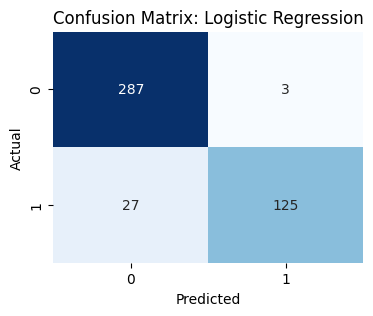

In [283]:
# Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_log = log_reg.predict(X_test)

# Evaluation
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("F1 Score:", f1_score(y_test, y_pred_log))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_log, "Logistic Regression")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Decision Tree:
Accuracy: 0.8099547511312217
F1 Score: 0.72


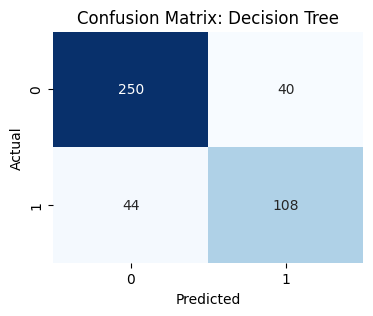

In [284]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)

# Evaluation
print("\nDecision Tree:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Random Forest:
Accuracy: 0.9366515837104072
F1 Score: 0.9014084507042254


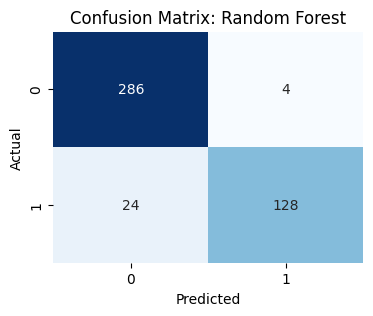

In [285]:
# Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Support Vector Machine:
Accuracy: 0.9434389140271493
F1 Score: 0.911660777385159


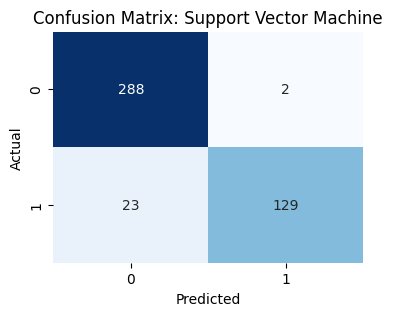

In [286]:
# SVM
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Predictions
y_pred_svm = svm.predict(X_test)

# Evaluation
print("\nSupport Vector Machine:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_svm, "Support Vector Machine")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Neural Network:
Accuracy: 0.9366515837104072
F1 Score: 0.903448275862069


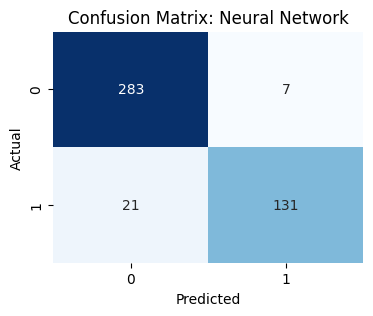

In [287]:
# Neural Network
mlp = MLPClassifier(random_state=42, max_iter=1000)
mlp.fit(X_train, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test)

# Evaluation
print("\nNeural Network:")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("F1 Score:", f1_score(y_test, y_pred_mlp))

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred_mlp, "Neural Network")


In [288]:
# Store model names and metrics
models = {
    "Logistic Regression": accuracy_score(y_test, y_pred_log),
    "Decision Tree": accuracy_score(y_test, y_pred_dt),
    "Random Forest": accuracy_score(y_test, y_pred_rf),
    "Support Vector Machine": accuracy_score(y_test, y_pred_svm),
    "Neural Network": accuracy_score(y_test, y_pred_mlp)
}

# Find the best model
best_model = max(models, key=models.get)
print(f"\nBest Model: {best_model} with Accuracy: {models[best_model]:.2f}")



Best Model: Support Vector Machine with Accuracy: 0.94


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Confusion Matrix for Support Vector Machine:
[[288   2]
 [ 23 129]]

Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       290
           1       0.98      0.85      0.91       152

    accuracy                           0.94       442
   macro avg       0.96      0.92      0.94       442
weighted avg       0.95      0.94      0.94       442



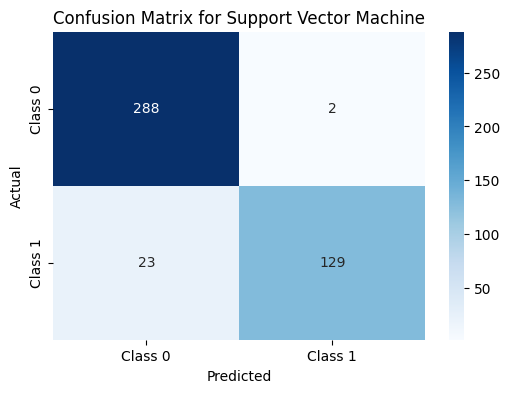

In [289]:
from sklearn.metrics import classification_report

# Store model predictions
predictions = {
    "Logistic Regression": y_pred_log,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf,
    "Support Vector Machine": y_pred_svm,
    "Neural Network": y_pred_mlp
}

# Find the best model's predictions
best_predictions = predictions[best_model]

# Calculate confusion matrix and classification report
cm = confusion_matrix(y_test, best_predictions)
report = classification_report(y_test, best_predictions)

# Print results
print(f"\nConfusion Matrix for {best_model}:")
print(cm)

print(f"\nClassification Report for {best_model}:")
print(report)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title(f"Confusion Matrix for {best_model}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#Section 8: Conclusion and Business recommendation


The analysis of customer reviews for Indian domestic airlines using text analytics techniques provided valuable insights into sentiment distribution, recurring themes, and actionable recommendations for improving customer satisfaction.

**Key Takeaways:**

*Sentiment Analysis:*
Airlines like Vistara and IndiGo have the highest proportion of positive sentiments, reflecting strong customer satisfaction.
Air India and SpiceJet show significant negative sentiments, emphasizing operational inefficiencies and poor customer experiences.

*Topic Modeling:*
Key pain points include baggage handling issues, flight delays, and customer care inefficiencies.
Positive feedback focused on crew behavior, cleanliness, and premium services.

*Classification Models:*
SVM emerged as the best-performing model, achieving the highest accuracy and F1 score. This model can reliably classify customer sentiments for real-time monitoring and issue identification.

*Actionable Insights:*
Operational Efficiency:
Airlines with frequent delays and cancellations (e.g., Air India, SpiceJet) need to prioritize scheduling improvements and proactive communication.

*Customer Care*:
Enhancing grievance redressal processes and staff training can reduce negative sentiments and improve satisfaction.

*Marketing:*
Positive sentiments around premium services (e.g., Vistara) can be leveraged for brand promotion and loyalty programs.

By adopting these insights and integrating them into business processes, airlines can significantly enhance customer satisfaction, strengthen their brand image, and drive long-term loyalty.